<img src="./mbit-logo.gif" align="right" style="float" width="55">
<font color="#CA3532"><h1 align="left">EJERCICIO: PROCESADO DE LENGUAJE NATURAL (NLP)</h1></font>
<font color="#CA3532"><h2 align="left">Máster en Big Data, Cloud & Analytics 2019-2020</h2></font>
<font color="#6E6E6E"><h4 align="left">Carlos Alfonsel <a> carlos.alfonsel@mbitschool.com </a> </h4></font> 

# Ejercicio de Procesado de Lenguaje Natural
En este ejercicio vamos a utilizar las técnicas aprendidas de NLP para clasificar la tipología de un conjunto de reclamaciones ciudadanas.  
Utilizaremos un modelo TF-IDF básico, y luego probaremos con bigrams y una reducción de dimensionalidad LSA para ver si obtenemos alguna mejora.

### Importación librerías

In [1]:
import numpy  as np
import pandas as pd
import spacy

pd.set_option('display.max_colwidth', None)

# Importa el resto de librerías necesarias:
import matplotlib.pyplot as plt
import seaborn           as sb
%matplotlib inline

# LIBRERÍAS PARA EXTRACCIÓN DE CARACTERÍSTICAS Y PARA ENTRENAMIENTO/VALIDACIÓN DE MODELOS DE ML:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection         import train_test_split
from sklearn.model_selection         import KFold
from sklearn.model_selection         import cross_val_score

# LIBRERÍAS NECESARIAS PARA MODELOS DE ML:
from sklearn.linear_model            import LinearRegression       # Modelo de Regresión Lineal
from sklearn.linear_model            import LogisticRegression     # Modelo de Regresión Logísitica
from sklearn.linear_model            import SGDClassifier          # Clasificador Lineal con SGD (Stochastic Gradient-Descent)
from sklearn.naive_bayes             import GaussianNB             # Modelo Naive-Bayes de tipo Gaussiano
from sklearn.naive_bayes             import MultinomialNB          # Modelo Naive-Bayes de tipo Multinomial
from sklearn.neighbors               import KNeighborsClassifier   # Modelo K-Nearest Neighbors
from sklearn.svm                     import SVC                    # Modelo Support Vector Machine
from sklearn.tree                    import DecisionTreeClassifier # Árbol de Decisión 
from sklearn.ensemble.forest         import RandomForestClassifier # Modelo Random-Forest 

# LIBRERÍAS NECESARIAS PARA OBTENER MÉTRICAS DE MODELOS DE ML:
from sklearn.metrics                 import accuracy_score
from sklearn.metrics                 import confusion_matrix
from sklearn.metrics                 import classification_report
from sklearn.metrics                 import roc_auc_score
from sklearn.metrics                 import mean_squared_error, r2_score

# LIBRERÍAS PARA PREPROCESADO Y LIMPIEZA DE TEXTO:
import re, string

# LIBRERÍA PARA CALCULAR MODELOS BASADOS EN WORD VECTORS:
import gensim

C:\Users\calfo\Anaconda3\envs\env_ml\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


### Carga de los datos
El archivo CSV de datos tiene tres columnas:  
- Observaciones: el texto (incidencia) a clasificar
- Tipología: la clase (etiqueta) de cada incidencia
- Original: característica binaria que no se usa en este problema

In [2]:
datos = pd.read_csv('incidencias.csv', sep = ";")
datos.sample(5)

,Tipología,Observaciones,Original
175,Mobiliario Urbano,"Cristal roto en la parada del autobus de la carretera, frente a la farmacia",NaN
106,Agua,No hay agua en los baños del area recreativa.,N
75,Agua,"Rota la fuente del merendero, se sale el agua.",N
100,Parques y jardines,Escombros al lado de la carretera. Parece de una obra cercana.,N
61,Alumbrado,Me falla la luz en la granja. Ha pasado dos días y esto no puede ser.,N


Muestra información del DataFrame y la cuenta de muestras en cada clase. ¿cuántas clases distintas hay? ¿están balanceadas?

In [3]:
# COMPLETAR:
datos.shape

(220, 3)

In [4]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tipología      220 non-null    object
 1   Observaciones  220 non-null    object
 2   Original       174 non-null    object
dtypes: object(3)
memory usage: 5.3+ KB


In [5]:
datos['Tipología'].unique()

array(['Vía Pública', 'Agua', 'Alcantarillado', 'Alumbrado', 'Limpieza',
       'Mobiliario Urbano', 'Parques y jardines',
       'Plagas de insectos y roedores'], dtype=object)

In [6]:
print('El número de tipos distintos de incidencias es: ' + str(len(datos['Tipología'].unique())))

El número de tipos distintos de incidencias es: 8


In [7]:
datos['Tipología'].value_counts()

Alumbrado                        31
Mobiliario Urbano                31
Parques y jardines               29
Vía Pública                      28
Limpieza                         28
Agua                             27
Alcantarillado                   26
Plagas de insectos y roedores    20
Name: Tipología, dtype: int64

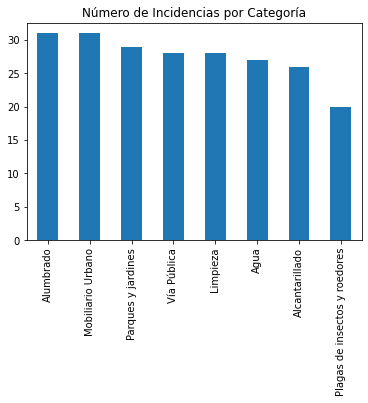

In [8]:
import matplotlib.pyplot as plt
plot = datos['Tipología'].value_counts().plot(kind = 'bar', title = 'Número de Incidencias por Categoría')

#### LAS 8 CLASES PARECEN ESTAR MÁS O MENOS BALANCEADAS.

In [9]:
# Eliminamos del dataframe la variable que no vamos a utilizar:
datos = datos.drop('Original', axis = 1)
datos.sample(5)

,Tipología,Observaciones
62,Plagas de insectos y roedores,Los topos me estan comiendo el grano de siembra. Hay que hacer algo para controlarlo.
29,Parques y jardines,Astillas en el tobogán del parque de la escuela
23,Mobiliario Urbano,al mirador se la han caído azulejos
125,Vía Pública,En la granja de Tomás los perros andan sueltos al lado de la carretera y corren persiguiendo a los coches.
175,Mobiliario Urbano,"Cristal roto en la parada del autobus de la carretera, frente a la farmacia"


### Limpieza del texto
Programa una función para limpiar el texto en los siguientes términos:  
- Elimina los números (expresión regular `r'\d+'`)  
- Elimina los signos de puntuación
- Convierte todas las palabras a minúscula

In [10]:
# COMPLETAR:
import spacy, re, string

# CARGAMOS EL MODELO DE LENGUAJE PARA ESPAÑOL:
nlp = spacy.load('es_core_news_md')

# Para eliminar símbolos de puntuación:
pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))

def clean_text(doc):
    '''Limpiamos y normalizamos un documento pasado como string'''
    # Se eliminan los números mediante la expresión regular r'\d+'
    doc = re.sub(r'\d+', '', doc)
    # Tokenizamos el texto:
    tokens = nlp(doc)
    # Se pasa a minúsculas y se eliminan los signos de puntuación:
    tokens = [tok.lower_ for tok in tokens if not tok.is_punct and not tok.is_space]
    filtered_tokens = [pattern.sub('', token) for token in tokens]
    # Lo unimos de nuevo en una cadena:
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text


Aplica la función de limpieza a la columna 'Observaciones' del DataFrame

In [11]:
# COMPLETAR:
datos.Observaciones = datos.Observaciones.apply(clean_text)
datos.sample(10)

,Tipología,Observaciones
39,Mobiliario Urbano,el cartel de entrada al pueblo está pintado y no se lee bien
203,Agua,el agua se puede beber directamente del grifo o está contaminado por nitratos
44,Vía Pública,hay un jabalí atropellado muerto en el camino al alto de la travina
175,Mobiliario Urbano,cristal roto en la parada del autobus de la carretera frente a la farmacia
3,Vía Pública,rejilla metálica al lado de la carretera frente a casa de catalina y pepe en mal estado se ha producido una caída
70,Alcantarillado,water atascado en los baños públicos del merendero
179,Parques y jardines,la fuente está llena de abejas y da miedo acercarse
13,Alumbrado,la tapa de la farola se la ha llevado el aire
14,Alumbrado,farola sin luz
121,Plagas de insectos y roedores,muchas abejas en la fuente de la mota no se puede acercar uno a menos que tenga mucho cuidado


In [12]:
datos.describe()

,Tipología,Observaciones
count,220,220
unique,8,219
top,Alumbrado,farola con bombilla colgando
freq,31,2


### Funciones auxiliares
Completa estas funciones para calcular la matriz BoW y TF-IDF del Corpus de texto. La función `train_predict_evaluate_model` ya está definida por ti.

In [13]:
# Función para extraer el modelo TF-IDF del corpus:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def bow_extractor(corpus, ngram_range = (1,1), min_df = 1, max_df = 1.0):
    '''Función que ajusta un modelo BoW sobre un corpus de texto y devuelve el modelo y la matriz BoW.
    El corpus se debe pasar como una lista de strings.'''
    # COMPLETAR:
    vectorizer = CountVectorizer(min_df = 1, max_df = 0.95)
    features   = vectorizer.fit_transform(corpus)
    return vectorizer, features

    
def tfidf_extractor(corpus, ngram_range = (1,1), min_df = 1, max_df = 1.0):
    '''Función que ajusta un modelo TF-IDF sobre un corpus de texto y devuelve el modelo y la matriz TF-IDF. 
    El corpus se debe pasar como una lista de strings.'''   
    # COMPLETAR:
    vectorizer = TfidfVectorizer(min_df = 1, max_df = 0.95)
    features   = vectorizer.fit_transform(corpus)
    return vectorizer, features

    
def train_predict_evaluate_model(classifier, train_features, train_labels, test_features, test_labels):
    '''Función que entrena un clasificador, lo evalúa sobre un conjunto de test, y muestra su rendimiento'''
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features) 
    # evaluate model prediction performance   
    print(classification_report(test_labels, predictions))
    return predictions 

### División del conjunto de datos
Divide los datos en un conjunto de entrenamiento (`X_train`, `y_train`) y test (`X_test`, `y_test`) en una proporción 70-30:

In [14]:
# COMPLETAR:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(datos['Observaciones'], datos['Tipología'], test_size = 0.3, random_state = 0)

In [15]:
X_train.sample(5)

49                                                                                       tejado hundido con la nevada
105                                                                        sin agua en las duchas y baños del camping
70                                                                 water atascado en los baños públicos del merendero
123                                                                         señal de tráfico tapada por la vegetación
177    a un banco en el parque de la fuente le falta un travesaño de madera y otro está roto no se puede sentar nadie
Name: Observaciones, dtype: object

In [16]:
y_train.sample(5)

170    Mobiliario Urbano
14             Alumbrado
148             Limpieza
94             Alumbrado
165    Mobiliario Urbano
Name: Tipología, dtype: object

## Clasificación
Entrena un clasificador sobre el conjunto de TRAIN y valida en TEST.  
Prueba con las matrices BoW y TF-IDF, y utiliza los siguientes clasificadores de la librería `scikit-learn`:  
```python
modelLR = LogisticRegression()
modelNB = GaussianNB()
modelSVM = SGDClassifier(loss='hinge', max_iter=100)
```
Guarda las predicciones de todos los modelos (luego la usarás para mostrar la matriz de confusión)

In [17]:
from sklearn.linear_model import LogisticRegression # Modelo de Regresión Logísitica
from sklearn.naive_bayes  import GaussianNB         # Modelo Naive-Bayes de tipo Gaussiano
from sklearn.naive_bayes  import MultinomialNB      # Modelo Naive-Bayes de tipo Multinomial
from sklearn.linear_model import SGDClassifier      # Clasificador Lineal con SGD (Stochastic Gradient-Descent)

modelLGR = LogisticRegression()
modelGNB = GaussianNB        ()
modelMNB = MultinomialNB     ()
modelSVM = SGDClassifier     (loss = 'hinge', max_iter = 100)

modelos1 = [('Logistic Regression'    , modelLGR),
            ('Multinomial Naive-Bayes', modelMNB),
            ('Linear SVM'             , modelSVM)]


#### CUANDO SE INTENTA APLICAR UN MODELO NAIVE-BAYES GAUSSIANO A ESTE DATASET SE PRODUCE UN ERROR AL SER LAS VARIABLES CATEGÓRICAS.
#### APLICAMOS POR TANTO UN MODELO NAIVE-BAYES MULTINOMIAL.

In [18]:
# 1.1. Entrenar clasificadores con modelos BoW.
# 1.2. Calcular matriz BoW sobre conjunto de entrenamiento y test.
# 1.3. Entrenar y validar los clasificadores.

bow_vectorizer, bow_train_features = bow_extractor(X_train)
bow_test_features                  = bow_vectorizer.transform(X_test)

for m, clf in modelos1:
    print('Modelo {} con características BoW'.format(m))
    tfidf_predictions = train_predict_evaluate_model(classifier     = clf, 
                                                     train_features = bow_train_features, 
                                                     train_labels   = y_train, 
                                                     test_features  = bow_test_features, 
                                                     test_labels    = y_test)


Modelo Logistic Regression con características BoW
                               precision    recall  f1-score   support

                         Agua       1.00      0.75      0.86         8
               Alcantarillado       0.45      0.50      0.48        10
                    Alumbrado       0.89      0.73      0.80        11
                     Limpieza       0.88      0.50      0.64        14
            Mobiliario Urbano       0.29      0.71      0.42         7
           Parques y jardines       0.44      0.80      0.57         5
Plagas de insectos y roedores       1.00      1.00      1.00         3
                  Vía Pública       0.67      0.25      0.36         8

                     accuracy                           0.61        66
                    macro avg       0.70      0.66      0.64        66
                 weighted avg       0.71      0.61      0.62        66

Modelo Multinomial Naive-Bayes con características BoW
                               precisio

In [19]:
# 2.1. Entrenar clasificadores con modelos TF-IDF.
# 2.2. Calcular matriz TF-IDF sobre conjunto de entrenamiento y test.
# 2.3. Entrenar y validar los clasificadores.

tfidf_vectorizer, tfidf_train_features = tfidf_extractor(X_train)
tfidf_test_features                    = tfidf_vectorizer.transform(X_test)

for m, clf in modelos1:
    print('Modelo {} con características TF-IDF'.format(m))
    tfidf_predictions = train_predict_evaluate_model(classifier     = clf, 
                                                     train_features = tfidf_train_features,
                                                     train_labels   = y_train,
                                                     test_features  = tfidf_test_features,
                                                     test_labels    = y_test)


Modelo Logistic Regression con características TF-IDF
                               precision    recall  f1-score   support

                         Agua       0.80      0.50      0.62         8
               Alcantarillado       1.00      0.50      0.67        10
                    Alumbrado       0.69      0.82      0.75        11
                     Limpieza       1.00      0.21      0.35        14
            Mobiliario Urbano       0.26      0.71      0.38         7
           Parques y jardines       0.38      1.00      0.56         5
Plagas de insectos y roedores       1.00      1.00      1.00         3
                  Vía Pública       0.40      0.25      0.31         8

                     accuracy                           0.55        66
                    macro avg       0.69      0.62      0.58        66
                 weighted avg       0.73      0.55      0.54        66

Modelo Multinomial Naive-Bayes con características TF-IDF
                               pr

C:\Users\calfo\Anaconda3\envs\env_ml\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


¿Cuál es el modelo que mejor funciona?  

#### EL MODELO QUE MEJOR FUNCIONA (EN TÉRMINOS DE ACCURACY) CON ESTE DATASET ES UN SVM LINEAL CON CARACTERÍSTICAS TF-IDF.

In [20]:
vect_opt = TfidfVectorizer(min_df = 1, ngram_range = (1,2), max_df = 0.5).fit(X_train)

X_train_vectorized = vect_opt.transform(X_train)
X_test_vectorized  = vect_opt.transform(X_test)

print('Entrenando con {} características'.format(len(vect_opt.get_feature_names())))

for m, clf in modelos1:
    print('Modelo {} con características TF-IDF optimizadas'.format(m))
    tfidf_predictions = train_predict_evaluate_model(classifier     = clf,
                                                     train_features = X_train_vectorized,
                                                     train_labels   = y_train,
                                                     test_features  = X_test_vectorized,
                                                     test_labels    = y_test)


Entrenando con 2125 características
Modelo Logistic Regression con características TF-IDF optimizadas
                               precision    recall  f1-score   support

                         Agua       0.80      0.50      0.62         8
               Alcantarillado       1.00      0.30      0.46        10
                    Alumbrado       0.60      0.82      0.69        11
                     Limpieza       1.00      0.21      0.35        14
            Mobiliario Urbano       0.29      0.86      0.43         7
           Parques y jardines       0.31      0.80      0.44         5
Plagas de insectos y roedores       1.00      0.67      0.80         3
                  Vía Pública       0.50      0.25      0.33         8

                     accuracy                           0.50        66
                    macro avg       0.69      0.55      0.52        66
                 weighted avg       0.72      0.50      0.49        66

Modelo Multinomial Naive-Bayes con caracter

Muestra la matriz de confusión sobre el conjunto de test usando el siguiente código (debes sustituir `prediccion` por el array de predicciones de tu mejor modelo):

In [21]:
prediccion = train_predict_evaluate_model(classifier     = modelSVM,
                                          train_features = X_train_vectorized,
                                          train_labels   = y_train,
                                          test_features  = X_test_vectorized,
                                          test_labels    = y_test)


                               precision    recall  f1-score   support

                         Agua       1.00      0.75      0.86         8
               Alcantarillado       0.67      0.80      0.73        10
                    Alumbrado       0.75      0.82      0.78        11
                     Limpieza       0.91      0.71      0.80        14
            Mobiliario Urbano       0.56      0.71      0.63         7
           Parques y jardines       0.38      0.60      0.46         5
Plagas de insectos y roedores       0.40      0.67      0.50         3
                  Vía Pública       0.67      0.25      0.36         8

                     accuracy                           0.68        66
                    macro avg       0.67      0.66      0.64        66
                 weighted avg       0.73      0.68      0.68        66



In [22]:
# Matriz de Confusión:
resultados = pd.DataFrame({'Real': y_test, 'Prediccion': prediccion})
pd.crosstab(resultados['Real'], resultados['Prediccion'], margins = True)

Prediccion,Agua,Alcantarillado,Alumbrado,Limpieza,Mobiliario Urbano,Parques y jardines,Plagas de insectos y roedores,Vía Pública,All
Real,,,,,,,,,
Agua,6,0,1,0,0,1,0,0,8
Alcantarillado,0,8,1,0,0,0,1,0,10
Alumbrado,0,0,9,0,1,0,1,0,11
Limpieza,0,2,0,10,1,0,0,1,14
Mobiliario Urbano,0,1,0,0,5,1,0,0,7
Parques y jardines,0,0,0,1,0,3,1,0,5
Plagas de insectos y roedores,0,0,1,0,0,0,2,0,3
Vía Pública,0,1,0,0,2,3,0,2,8
All,6,12,12,11,9,8,5,3,66


### Mejoras del clasificador
Como actividad opcional, intenta mejorar los resultados de estos clasificadores utilizando otras técnicas, como por ejemplo:  
- Distintos clasificadores a los utilizados
- Realizando una reducción de dimensionalidad LDA o LSA del texto
- Utilizando una matriz de características basada en Word Vectors o Paragraph Vectors

In [23]:
# PARA TRATAR DE MEJORAR LAS PREDICCIONES DE LOS MODELOS, DEFINIMOS UNA FUNCIÓN PARA EXTRAER LAS RAÍCES (LEMMAS):

def lemmatize_text(text):
    """Convertimos el texto a tokens, extraemos el lema de cada token
    y volvemos a convertir en cadena de texto"""
    tokens = nlp(text)
    lemmatized_tokens = [tok.lemma_ for tok in tokens]
    lemmatized_text = ' '.join(lemmatized_tokens)
    
    return lemmatized_text


In [24]:
datos.Observaciones = datos.Observaciones.apply(clean_text)
datos.sample(5)

,Tipología,Observaciones
88,Vía Pública,puerta rota en la casa abandonada de la parcela xxxx
212,Alcantarillado,rejilla embozada con restos de la cabalgata de reyes hay que recoger mejor el confetti y lo qque se tira
7,Agua,en el jardín botánico el grifo pierde
24,Mobiliario Urbano,el mirador del regajo está roto se ha caído la valla
92,Alcantarillado,arqueta de alcantarilla rota agujero peligroso para niños y mayores


### LEMMATIZAMOS LA VARIABLE "OBSERVACIONES" DE NUESTRO DATAFRAME:

In [25]:
datos['lemmas'] = datos.Observaciones.apply(lemmatize_text)
datos.sample(5)

,Tipología,Observaciones,lemmas
63,Mobiliario Urbano,bancos rotos pero recién pintados,banco roto pero recién pintar
37,Vía Pública,charco muy grande en la carretera al observatorio no se puede pasar en coche,charco muy grande en lo carretero al observatorio no se poder pasar en coche
98,Vía Pública,calle en muy mal estado necesito poder llegar a mi casa bien viven personas mayores,callar en muy mal estar necesitar poder llegar a mi casar bien vivir personar mayor
61,Alumbrado,me falla la luz en la granja ha pasado dos días y esto no puede ser,me fallo lo luz en lo granja haber pasar do día y este no poder ser
80,Vía Pública,coches aparcados de cualquier manera en la zona de la ermita molestan a los que vamos paseando y con niños,coche aparcar de cualquiera manera en lo zona de lo ermita molestar a lo que ir pasear y con niño


#### APLICAMOS NUESTROS MODELOS SOBRE LA VARIABLE "OBSERVACIONES" LIMPIADA Y LEMMATIZADA:

In [26]:
# DIVIDIMOS LOS DATOS (LIMPIADOS Y LEMMATIZADOS) EN DOS CONJUNTOS DE TRAINING (70% Y TEST (30%):

from sklearn.model_selection import train_test_split

# Split data into training and test sets:
X_train, X_test, y_train, y_test = train_test_split(datos['lemmas'], datos['Tipología'], test_size = 0.3, random_state = 0)


### NUEVOS CLASIFICADORES: ÁRBOLES DE DECISIÓN, RANDOM FOREST y K-NEAREST NEIGHBORS

In [27]:
# COMPLETAR:
from sklearn.tree            import DecisionTreeClassifier # Árbol de Decisión 
from sklearn.ensemble.forest import RandomForestClassifier # Modelo Random-Forest 
from sklearn.neighbors       import KNeighborsClassifier   # Modelo K-Nearest Neighbors

# DEFINIMOS LOS NUEVOS MODELOS QUE VAMOS A APLICAR A NUESTRO CONJUNTO DE DATOS:

modelDTC = DecisionTreeClassifier()
modelRFT = RandomForestClassifier()
modelKNN = KNeighborsClassifier()

modelos2 = [('Decision Tree Classifier', modelDTC),
            ('Random Forest'           , modelRFT),
            ('K-Nearest Neighbors'     , modelKNN)]


In [28]:
bow_vectorizer, bow_train_features = bow_extractor(X_train)
bow_test_features                  = bow_vectorizer.transform(X_test)

for m, clf in modelos2:
    print('Modelo {} con características BoW'.format(m))
    tfidf_predictions = train_predict_evaluate_model(classifier     = clf, 
                                                     train_features = bow_train_features, 
                                                     train_labels   = y_train, 
                                                     test_features  = bow_test_features, 
                                                     test_labels    = y_test)

tfidf_vectorizer, tfidf_train_features = tfidf_extractor(X_train)
tfidf_test_features                    = tfidf_vectorizer.transform(X_test)

for m, clf in modelos2:
    print('Modelo {} con características TF-IDF'.format(m))
    tfidf_predictions = train_predict_evaluate_model(classifier     = clf, 
                                                     train_features = tfidf_train_features,
                                                     train_labels   = y_train,
                                                     test_features  = tfidf_test_features,
                                                     test_labels    = y_test)


Modelo Decision Tree Classifier con características BoW
                               precision    recall  f1-score   support

                         Agua       1.00      0.50      0.67         8
               Alcantarillado       0.80      0.80      0.80        10
                    Alumbrado       1.00      0.91      0.95        11
                     Limpieza       1.00      0.21      0.35        14
            Mobiliario Urbano       0.38      0.43      0.40         7
           Parques y jardines       0.50      0.40      0.44         5
Plagas de insectos y roedores       0.60      1.00      0.75         3
                  Vía Pública       0.23      0.62      0.33         8

                     accuracy                           0.58        66
                    macro avg       0.69      0.61      0.59        66
                 weighted avg       0.75      0.58      0.59        66

Modelo Random Forest con características BoW
                               precision    

In [29]:
vect_opt = TfidfVectorizer(min_df = 1, ngram_range = (1,2), max_df = 0.5).fit(X_train)

X_train_vectorized = vect_opt.transform(X_train)
X_test_vectorized  = vect_opt.transform(X_test)

print('Entrenando con {} características'.format(len(vect_opt.get_feature_names())))

for m, clf in modelos2:
    print('Modelo {} con características TF-IDF optimizadas'.format(m))
    tfidf_predictions = train_predict_evaluate_model(classifier     = clf,
                                                     train_features = X_train_vectorized,
                                                     train_labels   = y_train,
                                                     test_features  = X_test_vectorized,
                                                     test_labels    = y_test)


Entrenando con 1935 características
Modelo Decision Tree Classifier con características TF-IDF optimizadas
                               precision    recall  f1-score   support

                         Agua       0.86      0.75      0.80         8
               Alcantarillado       0.78      0.70      0.74        10
                    Alumbrado       1.00      0.91      0.95        11
                     Limpieza       0.88      0.50      0.64        14
            Mobiliario Urbano       0.25      0.43      0.32         7
           Parques y jardines       0.43      0.60      0.50         5
Plagas de insectos y roedores       0.75      1.00      0.86         3
                  Vía Pública       0.44      0.50      0.47         8

                     accuracy                           0.65        66
                    macro avg       0.67      0.67      0.66        66
                 weighted avg       0.72      0.65      0.67        66

Modelo Random Forest con característic

#### EL MODELO QUE MEJOR FUNCIONA (EN TÉRMINOS DE ACCURACY) CON ESTE DATASET LIMPIADO y LEMMATIZADO ES UN ÁRBOL DE DECISIÓN CON CARACTERÍSTICAS TF-IDF.

In [30]:
prediccion = train_predict_evaluate_model(classifier     = modelDTC,
                                          train_features = X_train_vectorized,
                                          train_labels   = y_train,
                                          test_features  = X_test_vectorized,
                                          test_labels    = y_test)


                               precision    recall  f1-score   support

                         Agua       0.86      0.75      0.80         8
               Alcantarillado       0.60      0.60      0.60        10
                    Alumbrado       1.00      0.91      0.95        11
                     Limpieza       0.88      0.50      0.64        14
            Mobiliario Urbano       0.27      0.43      0.33         7
           Parques y jardines       0.50      0.60      0.55         5
Plagas de insectos y roedores       0.75      1.00      0.86         3
                  Vía Pública       0.40      0.50      0.44         8

                     accuracy                           0.64        66
                    macro avg       0.66      0.66      0.65        66
                 weighted avg       0.70      0.64      0.65        66



In [31]:
# Matriz de Confusión:
resultados = pd.DataFrame({'Real': y_test, 'Prediccion': prediccion})
pd.crosstab(resultados['Real'], resultados['Prediccion'], margins = True)

Prediccion,Agua,Alcantarillado,Alumbrado,Limpieza,Mobiliario Urbano,Parques y jardines,Plagas de insectos y roedores,Vía Pública,All
Real,,,,,,,,,
Agua,6,0,0,0,1,1,0,0,8
Alcantarillado,1,6,0,0,1,1,0,1,10
Alumbrado,0,0,10,0,1,0,0,0,11
Limpieza,0,1,0,7,3,0,1,2,14
Mobiliario Urbano,0,1,0,1,3,0,0,2,7
Parques y jardines,0,0,0,0,1,3,0,1,5
Plagas de insectos y roedores,0,0,0,0,0,0,3,0,3
Vía Pública,0,2,0,0,1,1,0,4,8
All,7,10,10,8,11,6,4,10,66


### REDUCCIÓN DE DIMENSIONALIDAD LSA (Latent Semantic Analysis)

In [32]:
datos = pd.read_csv('incidencias.csv', sep = ";")
datos = datos.drop('Original', axis = 1)

In [33]:
datos.Observaciones = datos.Observaciones.apply(clean_text)
datos['lemmas']     = datos.Observaciones.apply(lemmatize_text)

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(datos['lemmas'], datos['Tipología'], test_size = 0.3, random_state = 0)

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition           import TruncatedSVD
from sklearn.preprocessing           import Normalizer
from sklearn.pipeline                import make_pipeline

def lsa_extractor(corpus, n_dim = 100):
    '''(vectorizer, features) = lsa_extractor(corpus, n_dim=50)
    Función que genera un modelo Latent Semantic Analysis
    sobre un corpus de texto (pasado como lista de textos)
    utilizando n_dim dimensiones
    Devuelve el modelo LSA ya entrenado y el vector sobre el corpus'''
    
    tfidf      = TfidfVectorizer(use_idf = True)
    svd        = TruncatedSVD(n_dim)
    vectorizer = make_pipeline(tfidf, svd, Normalizer(copy = False))
    features   = vectorizer.fit_transform(corpus)
    return vectorizer, features


In [36]:
# Creamos los vectores de características LSA con 100 dimensiones:
lsa_vectorizer, lsa_train_features = lsa_extractor(X_train, n_dim = 100)  
lsa_test_features                  = lsa_vectorizer.transform(X_test)


In [37]:
modelos = [('Logistic Regression'     , modelLGR),
           ('Random Forest'           , modelRFT),
           ('K-Nearest Neighbors'     , modelKNN),
           ('Linear SVM'              , modelSVM)]

# Entrenamos y validamos:
for m, clf in modelos:
    print('Modelo {} con características LSA-100:'.format(m))
    tfidf_predictions = train_predict_evaluate_model(classifier     = clf,
                                                     train_features = lsa_train_features,
                                                     train_labels   = y_train,
                                                     test_features  = lsa_test_features,
                                                     test_labels    = y_test)

Modelo Logistic Regression con características LSA-100:
                               precision    recall  f1-score   support

                         Agua       1.00      0.75      0.86         8
               Alcantarillado       0.80      0.80      0.80        10
                    Alumbrado       0.91      0.91      0.91        11
                     Limpieza       1.00      0.43      0.60        14
            Mobiliario Urbano       0.45      0.71      0.56         7
           Parques y jardines       0.42      1.00      0.59         5
Plagas de insectos y roedores       0.60      1.00      0.75         3
                  Vía Pública       0.40      0.25      0.31         8

                     accuracy                           0.68        66
                    macro avg       0.70      0.73      0.67        66
                 weighted avg       0.76      0.68      0.68        66

Modelo Random Forest con características LSA-100:
                               precisio

### MODELO CON WORD EMBEDDINGS:

In [38]:
tokens = nlp(datos.Observaciones[1])
tokens[1].vector.shape

(50,)

In [39]:
issues = nlp(datos.Observaciones[1])
issues.vector.shape

(50,)

In [40]:
word_embeddings = np.zeros((len(datos.Observaciones), issues.vector.shape[0]))

In [41]:
vectors = [nlp(issues).vector for issues in datos.Observaciones]

for i,vector in enumerate(vectors):
    word_embeddings[i,:] = vector

word_embeddings.shape

(220, 50)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(word_embeddings, 
                                                    datos['Tipología'], 
                                                    test_size    = 0.3,
                                                    random_state = 0)

In [43]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm         import SVC

modelLGR = LogisticRegression    ()
modelDTC = DecisionTreeClassifier()
modelRFT = RandomForestClassifier()
modelGNB = GaussianNB            ()
modelKNN = KNeighborsClassifier  ()

modelos = [('Logistic Regression'     , modelLGR),
           ('Decision Tree Classifier', modelDTC),
           ('Random Forest'           , modelRFT),
           ('Gaussian Naive-Bayes'    , modelGNB),
           ('K-Nearest Neighbors'     , modelKNN)]

for m, clf in modelos:
    print('Modelo {} con características Word Embeddings promediados'.format(m))
    tfidf_predictions = train_predict_evaluate_model(classifier     = clf,
                                                     train_features = X_train,
                                                     train_labels   = y_train,
                                                     test_features  = X_test,
                                                     test_labels    = y_test)


Modelo Logistic Regression con características Word Embeddings promediados
                               precision    recall  f1-score   support

                         Agua       0.80      0.50      0.62         8
               Alcantarillado       0.71      0.50      0.59        10
                    Alumbrado       0.50      0.64      0.56        11
                     Limpieza       0.64      0.50      0.56        14
            Mobiliario Urbano       0.14      0.14      0.14         7
           Parques y jardines       0.11      0.20      0.14         5
Plagas de insectos y roedores       0.33      0.67      0.44         3
                  Vía Pública       0.43      0.38      0.40         8

                     accuracy                           0.45        66
                    macro avg       0.46      0.44      0.43        66
                 weighted avg       0.51      0.45      0.47        66

Modelo Decision Tree Classifier con características Word Embeddings pr

C:\Users\calfo\Anaconda3\envs\env_ml\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## CONCLUSIONES:

- EL LEMMATIZADO DE LA VARIABLE TARGET MEJORA LOS RESULTADOS.
- APLICAR UNA REDUCCIÓN DE DIMENSIONALIDAD LSA (Latent Semantic Analysis) MEJORA SIGNIFICATIVAMENTE LOS RESULTADOS.
- LOS MODELOS CON WORD EMBEDDING PROMEDIADO FUNCIONAN PEOR QUE LOS MODELOS MÁS SIMPLES (BoW, TF-IDF) DEBIDO A QUE NUESTRO CONJUNTO DE DATOS ES MUY PEQUEÑO.
- MEJOR ALGORITMO ENCONTRADO: MODELO DE REGRESIÓN LOGÍSTICA, CON CARACTERÍSTICAS TF-IDF, CON DATASET LEMMATIZADO Y REDUCCIÓN LSA DE 100 DIMENSIONES. 